In [1]:
import pandas as pd
import pickle
import os

In [187]:
model_map_name = {
    "qwen": "Qwen2",
    "Mistral-7B-Instruct-v0.3": "Mistral v0.3",
    "gemma-7b-it": "Gemma 1.1",
    "gemma-1.1-7b-it": "Gemma 1.1",
    "Meta-Llama-3-8B-Instruct": "Llama 3",
    "llama3.1": "Llama 3.1",
    "led_tiny": "LED-Tiny",
    "primera_tiny": "Primera-Tiny",
    "led_short": "LED-Short",
    "primera_short": "Primera-Short",
    "led_long": "LED-Long",
    "primera_long": "Primera-Long"
}

pipeline_map_name = {
    "first5last5_bert": "F5L5 + BES" ,
    "first5last5_textrank": "F5L5 + TR", 
    "first5last5": "F5L5",
    "random_selection_bert": "RS + BES",
    "random_selection_textrank": "RS + TR",
    "random_selection": "RS",
    "None": ""
}

pipeline_map_name_eurlexsum = {
    "random_selection_bert": "BES",
    "random_selection_textrank": "TR",
    "None": "None"
}

prompt_type_map = {
    "basic": "Basic",
    "detailed": "Policy-Informed",
    "cod": "CoD",
    "basic_eurlex": "Basic",
    "detailed_eurlex": "Policy-Informed",
    "cod_eurlex": "CoD",
    "None": "None"
}

dataset_map = {
    "tiny": "MultiLEX Tiny",
    "multilex_tiny": "MultiLEX Tiny",
    "short": "MultiLEX Short",
    "multilex_short": "MultiLEX Short",
    "long": "MultiLEX Long",
    "multilex_long": "MultiLEX Long",
    "eurlexsum_test": "EURLEXSum Test"
}

In [188]:
dataset_tables = {}
summ_types = ["tiny", "short", "long", "eurlexsum_test"]
for summ_type in summ_types:
    dfs = []
    for result_file in os.listdir():
        if not result_file.endswith("pickle"):
            continue
        if summ_type not in result_file:
            continue
        df = pd.read_pickle(result_file)
        if "qwen" in df["model"] or "llama3.1" in df["model"]:
            df["selection_type"] = ["None"] * len(df["model"])
        if "primera" in df["model"][0] or "led" in df["model"][0]:
            if len(df["score_value"]) == 5:
                df["prompt_type"] = ["None"] * 5
                continue
            df["model"] = [df["model"][0]] * 5 + [df["model"][1]] * 5
            df["prompt_type"] = ["None"] * len(df["score_value"])
            df["selection_type"] = ["random_selection"] * 5 + ["first5last5"] * 5
        df = pd.DataFrame(df)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[df["score_type"] != "mover_score"]
    df = df[~df["model"].str.contains("mixtral")]
    df = df[~df["prompt_type"].str.contains("cod")] ########################## REMOVED COD
    df = df.reset_index(drop=True)
    if "eurlexsum" not in summ_type:
        df["prompt_type"] = df["prompt_type"].apply(lambda x: x.split("_")[-1])
    else:
        def get_prompt_type(x):
            x = x.split("_")
            if len(x) > 2:
                x = x[1]
            else:
                x = x[-1]
            return x
        df["prompt_type"] = df["prompt_type"].apply(lambda x: get_prompt_type(x))
    df = df.copy(True).reset_index(drop=True)
    df = [df.iloc[idx:idx+4].to_numpy() for idx in range(0,len(df),4)]
    rows = []
    for row in df:
        rows += [[row[0][0], row[0][1], row[0][2], row[0][3], row[1][3], row[2][3], row[3][3]]]

    df = pd.DataFrame(rows, columns=["model", "selection_type", "prompt_type", "R1", "R2", "RL", "BS"])
    df["model"] = [model_map_name[name] for name in df["model"]]
    df["selection_type"] = [pipeline_map_name[name] for name in df["selection_type"]]
    df["prompt_type"] = [prompt_type_map[name] for name in df["prompt_type"]]

    from collections import defaultdict
    latex_dict = defaultdict(dict)
    for idx, row in df.iterrows():
        key = (row["selection_type"] + " + " if row["selection_type"] != "None" else "") + row["model"]

        max_value_r1 = str(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["R1"]))
        max_value_r2 = str(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["R2"]))
        max_value_rl = str(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["RL"]))
        max_value_bs = str(round(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["BS"]),3))
        r1_val = f'\\textbf{{{str(row["R1"])}}}' if str(row["R1"]) == max_value_r1 else str(row["R1"])
        r2_val = f'\\textbf{{{str(row["R2"])}}}' if str(row["R2"]) == max_value_r2 else str(row["R2"])
        rl_val = f'\\textbf{{{str(row["RL"])}}}' if str(row["RL"]) == max_value_rl else str(row["RL"])
        bs_val = f'\\textbf{{{str(round(row["BS"],3))}}}' if str(round(row["BS"],3)) == max_value_bs else str(round(row["BS"],3))

        latex_dict[key][row["prompt_type"]] = [r1_val, r2_val, rl_val, bs_val]

    # prompt_types = ["Basic", "Policy-Informed", "CoD"]
    prompt_types = ["Basic", "Policy-Informed"]
    latex_rows_elas = []
    latex_rows_longcontext = []
    latex_rows_ablation = []

    for model in latex_dict.keys():
        if "primera" in model.lower() or "led" in model.lower():
            row = model + " & " + " & ".join(latex_dict[model]["None"]) + "\\\\"
            latex_rows_ablation += [row]
        else: 
            row = model + " & "
            for prompt in prompt_types:
                row += " & ".join(latex_dict[model][prompt]) + " & "
            row = row[:-2]
            row += "\\\\" 
            if "qwen" in model.lower() or "llama 3.1" in model.lower():
                latex_rows_longcontext += [row]
            else:
                latex_rows_elas += [row]
    dataset_tables[summ_type] = (latex_rows_elas, latex_rows_longcontext, latex_rows_ablation)

In [189]:
dataset_tables.keys()

dict_keys(['tiny', 'short', 'long', 'eurlexsum_test'])

In [190]:
latex_rows_elas = dataset_tables["tiny"][0]
latex_rows_longcontext = dataset_tables["tiny"][1]
latex_rows_ablation = dataset_tables["tiny"][2]
print("Pipeline\n----------------------")
print("\n".join(latex_rows_elas) + "\n")
print("LongContext\n----------------------")
print("\n".join(latex_rows_longcontext) + "\n")
print("Ablation\n----------------------")
print("\n".join(latex_rows_ablation))

Pipeline
----------------------
F5L5 + BES + Mistral v0.3 & 0.181 & 0.044 & 0.139 & 0.62 & 0.169 & 0.037 & 0.13 & \textbf{0.663} \\
RS + BES + Mistral v0.3 & 0.178 & 0.042 & 0.136 & 0.62 & 0.171 & 0.04 & 0.132 & 0.527 \\
RS + TR + Mistral v0.3 & 0.189 & 0.047 & 0.145 & \textbf{0.681} & 0.17 & 0.039 & 0.129 & 0.635 \\
F5L5 + TR + Mistral v0.3 & 0.185 & 0.046 & 0.141 & \textbf{0.681} & 0.168 & 0.038 & 0.126 & 0.635 \\
F5L5 + BES + Gemma 1.1 & \textbf{0.234} & 0.054 & 0.169 & 0.645 & 0.226 & 0.058 & 0.166 & 0.607 \\
RS + BES + Gemma 1.1 & 0.231 & 0.056 & 0.167 & 0.616 & \textbf{0.23} & \textbf{0.06} & \textbf{0.169} & 0.608 \\
RS + TR + Gemma 1.1 & 0.233 & \textbf{0.064} & \textbf{0.173} & 0.611 & 0.216 & 0.057 & 0.158 & 0.562 \\
F5L5 + TR + Gemma 1.1 & 0.228 & 0.062 & 0.169 & 0.611 & 0.218 & 0.058 & 0.161 & 0.464 \\
F5L5 + BES + Llama 3 & 0.195 & 0.046 & 0.141 & 0.629 & 0.177 & 0.04 & 0.128 & 0.559 \\
RS + BES + Llama 3 & 0.187 & 0.042 & 0.136 & 0.629 & 0.177 & 0.039 & 0.128 & 0.559 \\
R

In [191]:
latex_rows_elas = dataset_tables["short"][0]
latex_rows_longcontext = dataset_tables["short"][1]
latex_rows_ablation = dataset_tables["short"][2]
print("Pipeline\n----------------------")
print("\n".join(latex_rows_elas) + "\n")
print("LongContext\n----------------------")
print("\n".join(latex_rows_longcontext) + "\n")
print("Ablation\n----------------------")
print("\n".join(latex_rows_ablation))

Pipeline
----------------------
F5L5 + BES + Mistral v0.3 & 0.388 & 0.131 & 0.225 & 0.624 & 0.398 & 0.137 & 0.23 & \textbf{0.629} \\
RS + BES + Mistral v0.3 & 0.383 & 0.125 & 0.221 & 0.621 & 0.394 & 0.136 & 0.227 & 0.627 \\
RS + TR + Mistral v0.3 & 0.377 & 0.128 & 0.22 & 0.616 & 0.385 & 0.138 & 0.226 & 0.619 \\
F5L5 + TR + Mistral v0.3 & 0.381 & 0.132 & 0.223 & 0.619 & 0.391 & 0.142 & 0.229 & 0.621 \\
F5L5 + BES + Gemma 1.1 & 0.385 & 0.118 & 0.221 & 0.588 & 0.381 & 0.117 & 0.216 & 0.583 \\
RS + BES + Gemma 1.1 & 0.379 & 0.114 & 0.217 & 0.585 & 0.378 & 0.114 & 0.213 & 0.581 \\
RS + TR + Gemma 1.1 & 0.378 & 0.12 & 0.22 & 0.579 & 0.379 & 0.119 & 0.218 & 0.573 \\
F5L5 + TR + Gemma 1.1 & 0.379 & 0.12 & 0.219 & 0.579 & 0.382 & 0.121 & 0.219 & 0.574 \\
F5L5 + BES + Llama 3 & 0.39 & 0.136 & 0.227 & 0.624 & 0.402 & 0.15 & 0.229 & 0.625 \\
RS + BES + Llama 3 & 0.385 & 0.132 & 0.224 & 0.62 & \textbf{0.403} & 0.151 & 0.231 & 0.627 \\
RS + TR + Llama 3 & 0.379 & 0.13 & 0.224 & 0.609 & 0.371 & 0.138

In [192]:
latex_rows_elas = dataset_tables["long"][0]
latex_rows_longcontext = dataset_tables["long"][1]
latex_rows_ablation = dataset_tables["long"][2]
print("Pipeline\n----------------------")
print("\n".join(latex_rows_elas) + "\n")
print("LongContext\n----------------------")
print("\n".join(latex_rows_longcontext) + "\n")
print("Ablation\n----------------------")
print("\n".join(latex_rows_ablation))

Pipeline
----------------------
F5L5 + BES + Mistral v0.3 & 0.398 & 0.153 & 0.205 & 0.597 & 0.425 & 0.166 & 0.209 & \textbf{0.602} \\
RS + BES + Mistral v0.3 & 0.394 & 0.151 & 0.203 & 0.596 & 0.421 & 0.164 & 0.207 & 0.601 \\
RS + TR + Mistral v0.3 & 0.383 & 0.153 & 0.203 & 0.593 & 0.41 & 0.165 & 0.209 & 0.598 \\
F5L5 + TR + Mistral v0.3 & 0.383 & 0.154 & 0.203 & 0.594 & 0.411 & 0.167 & 0.209 & 0.599 \\
F5L5 + BES + Gemma 1.1 & 0.387 & 0.129 & 0.193 & 0.567 & 0.394 & 0.135 & 0.193 & 0.568 \\
RS + BES + Gemma 1.1 & 0.385 & 0.129 & 0.193 & 0.567 & 0.394 & 0.134 & 0.193 & 0.567 \\
RS + TR + Gemma 1.1 & 0.383 & 0.131 & 0.196 & 0.566 & 0.392 & 0.134 & 0.197 & 0.566 \\
F5L5 + TR + Gemma 1.1 & 0.386 & 0.132 & 0.197 & 0.567 & 0.395 & 0.136 & 0.198 & 0.567 \\
F5L5 + BES + Llama 3 & \textbf{0.435} & 0.166 & \textbf{0.217} & \textbf{0.599} & \textbf{0.433} & \textbf{0.169} & 0.21 & 0.596 \\
RS + BES + Llama 3 & 0.432 & 0.163 & 0.215 & 0.598 & \textbf{0.433} & 0.168 & 0.209 & 0.596 \\
RS + TR + Lla

In [193]:
import re

regex_pattern = r"(?:& )?[\w]+ \+ [\w]+ & "
ablation_tiny = dataset_tables["tiny"][2]
ablation_short = dataset_tables["short"][2]
ablation_long = dataset_tables["long"][2]

def process_row(x: str, s_type):
    x = x.replace(f"-{s_type}", "")
    x = x[:-2] # remove \\
    if s_type.lower() in ["short", "long"]:
        x = re.sub(regex_pattern, "", x)

    return x

for ed_tiny, ed_short, ed_long in zip(ablation_tiny, ablation_short, ablation_long):
    ed_tiny, ed_short, ed_long = process_row(ed_tiny, "Tiny"), process_row(ed_short, "Short"), process_row(ed_long, "Long")
    row = " & ".join([ed_tiny, ed_short, ed_long]) + " \\\\"
    print(row)

RS + Primera & 0.213 & 0.058 & 0.166 & 0.618 & 0.384 & 0.15 & 0.252 & 0.632 & \textbf{0.437} & \textbf{0.209} & \textbf{0.263} & \textbf{0.624} \\
F5L5 + Primera & 0.211 & 0.058 & 0.166 & 0.617 & 0.381 & 0.15 & 0.252 & 0.631 & 0.433 & 0.208 & \textbf{0.263} & 0.621 \\
RS + LED & \textbf{0.245} & \textbf{0.076} & \textbf{0.195} & \textbf{0.639} & 0.422 & 0.185 & 0.284 & 0.656 & 0.435 & 0.183 & 0.24 & 0.61 \\
F5L5 + LED & 0.237 & 0.071 & 0.189 & 0.632 & \textbf{0.425} & \textbf{0.189} & \textbf{0.287} & \textbf{0.659} & 0.435 & 0.182 & 0.24 & 0.609 \\


In [194]:
def get_prompt_type(x):
    x = x.split("_")
    if len(x) > 2:
        x = x[1]
    else:
        x = x[-1]
    return x

dfs = []
summ_types = ["test", "validation"]
dataset_tables = {}
for summ_type in summ_types:
    for result_file in os.listdir():
        if not result_file.endswith("pickle"):
            continue
        if summ_type not in result_file or "eurlexsum" not in result_file:
            continue
        df = pd.read_pickle(result_file)
        if "qwen" in df["model"] or "llama3.1" in df["model"]:
            df["selection_type"] = ["None"] * len(df["model"])
        df = pd.DataFrame(df)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[df["score_type"] != "mover_score"]
    df = df[~df["model"].str.contains("mixtral")]
    df = df[~df["prompt_type"].str.contains("cod")] ###### REMOVED COD
    df = df.reset_index(drop=True)
    df["prompt_type"] = df["prompt_type"].apply(lambda x: get_prompt_type(x))
    df = df.copy(True).reset_index(drop=True)
    df = [df.iloc[idx:idx+4].to_numpy() for idx in range(0,len(df),4)]
    rows = []
    for row in df:
        rows += [[row[0][0], row[0][1], row[0][2], row[0][3], row[1][3], row[2][3], row[3][3]]]

    df = pd.DataFrame(rows, columns=["model", "selection_type", "prompt_type", "R1", "R2", "RL", "BS"])
    df["model"] = [model_map_name[name] for name in df["model"]]
    df["selection_type"] = [pipeline_map_name_eurlexsum[name] for name in df["selection_type"]]
    df["prompt_type"] = [prompt_type_map[name] for name in df["prompt_type"]]

    from collections import defaultdict
    latex_dict = defaultdict(dict)
    for idx, row in df.iterrows():
        key = (row["selection_type"] + " + " if row["selection_type"] != "None" else "") + row["model"]

        max_value_r1 = str(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["R1"]))
        max_value_r2 = str(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["R2"]))
        max_value_rl = str(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["RL"]))
        max_value_bs = str(round(max(df[df["prompt_type"].str.contains(row["prompt_type"])]["BS"]),3))
        r1_val = f'\\textbf{{{str(row["R1"])}}}' if str(row["R1"]) == max_value_r1 else str(row["R1"])
        r2_val = f'\\textbf{{{str(row["R2"])}}}' if str(row["R2"]) == max_value_r2 else str(row["R2"])
        rl_val = f'\\textbf{{{str(row["RL"])}}}' if str(row["RL"]) == max_value_rl else str(row["RL"])
        bs_val = f'\\textbf{{{str(round(row["BS"],3))}}}' if str(round(row["BS"],3)) == max_value_bs else str(round(row["BS"],3))

        latex_dict[key][row["prompt_type"]] = [r1_val, r2_val, rl_val, bs_val]

    # prompt_types = ["Basic", "Policy-Informed", "CoD"]
    prompt_types = ["Basic", "Policy-Informed"]
    latex_rows_elas = []
    latex_rows_longcontext = []
    latex_rows_ablation = []

    for model in latex_dict.keys():
        row = model + " & "
        for prompt in prompt_types:
            row += " & ".join(latex_dict[model][prompt]) + " & "
        row = row[:-2]
        row += "\\\\" 
        if "qwen" in model.lower() or "llama 3.1" in model.lower():
            latex_rows_longcontext += [row]
        else:
            latex_rows_elas += [row]

    dataset_tables[summ_type] = (latex_rows_elas, latex_rows_longcontext)

In [195]:
latex_rows_elas = dataset_tables["test"][0]
latex_rows_longcontext = dataset_tables["test"][1]

print("Pipeline\n----------------------")
print("\n".join(latex_rows_elas) + "\n")
print("LongContext\n----------------------")
print("\n".join(latex_rows_longcontext))

Pipeline
----------------------
BES + Mistral v0.3 & 0.322 & 0.107 & 0.155 & 0.506 & 0.386 & 0.138 & 0.182 & 0.545 \\
TR + Mistral v0.3 & 0.371 & 0.129 & 0.171 & 0.536 & 0.425 & 0.16 & 0.196 & 0.576 \\
BES + Gemma 1.1 & 0.265 & 0.087 & 0.138 & 0.505 & 0.307 & 0.105 & 0.155 & 0.523 \\
TR + Gemma 1.1 & 0.32 & 0.112 & 0.162 & 0.518 & 0.329 & 0.114 & 0.164 & 0.522 \\
BES + Llama 3 & 0.354 & 0.119 & 0.17 & 0.518 & 0.42 & 0.153 & 0.198 & 0.564 \\
TR + Llama 3 & 0.384 & 0.141 & 0.184 & 0.535 & 0.442 & 0.169 & 0.206 & 0.578 \\

LongContext
----------------------
Llama 3.1 & \textbf{0.505} & \textbf{0.211} & \textbf{0.236} & \textbf{0.625} & \textbf{0.51} & \textbf{0.213} & \textbf{0.236} & \textbf{0.633} \\
Qwen2 & 0.478 & 0.187 & 0.212 & 0.596 & 0.463 & 0.171 & 0.202 & 0.597 \\


In [196]:
latex_rows_elas = dataset_tables["validation"][0]
latex_rows_longcontext = dataset_tables["validation"][1]

print("Pipeline\n----------------------")
print("\n".join(latex_rows_elas) + "\n")
print("LongContext\n----------------------")
print("\n".join(latex_rows_longcontext))

Pipeline
----------------------
BES + Mistral v0.3 & 0.323 & 0.109 & 0.157 & 0.508 & 0.384 & 0.14 & 0.182 & 0.548 \\
TR + Mistral v0.3 & 0.373 & 0.137 & 0.173 & 0.537 & 0.43 & 0.166 & 0.197 & 0.576 \\
BES + Gemma 1.1 & 0.269 & 0.09 & 0.139 & 0.509 & 0.304 & 0.106 & 0.155 & 0.524 \\
TR + Gemma 1.1 & 0.323 & 0.117 & 0.163 & 0.518 & 0.331 & 0.121 & 0.167 & 0.525 \\
BES + Llama 3 & 0.349 & 0.118 & 0.167 & 0.517 & 0.417 & 0.154 & 0.197 & 0.563 \\
TR + Llama 3 & 0.393 & 0.151 & 0.19 & 0.538 & 0.44 & 0.171 & 0.207 & 0.58 \\

LongContext
----------------------
Llama 3.1 & \textbf{0.508} & \textbf{0.216} & \textbf{0.238} & 0.624 & 0.509 & \textbf{0.215} & \textbf{0.236} & \textbf{0.634} \\
Qwen2 & 0.464 & 0.181 & 0.206 & 0.591 & 0.462 & 0.171 & 0.202 & 0.592 \\


In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

llm_order = ['Mistral-7B-Instruct-v0.3', 'gemma-7b-it', 'gemma-1.1-7b-it', 'Meta-Llama-3-8B-Instruct', 'qwen', 'llama3.1']

In [198]:
dataset_tables = {}
summ_types = ["tiny", "short", "long", "eurlexsum_test"]
for summ_type in summ_types:
    dfs = []
    for result_file in os.listdir():
        if not result_file.endswith("pickle"):
            continue
        if summ_type not in result_file:
            continue
        df = pd.read_pickle(result_file)
        if "qwen" in df["model"] or "llama3.1" in df["model"]:
            df["selection_type"] = ["None"] * len(df["model"])
        if "primera" in df["model"][0] or "led" in df["model"][0]:
            if len(df["score_value"]) == 5:
                df["prompt_type"] = ["None"] * 5
                continue
            df["model"] = [df["model"][0]] * 5 + [df["model"][1]] * 5
            df["prompt_type"] = ["None"] * len(df["score_value"])
            df["selection_type"] = ["random_selection"] * 5 + ["first5last5"] * 5
        df = pd.DataFrame(df)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[df["score_type"] != "mover_score"]
    ###################################
    df = df[~df["model"].str.contains("mixtral")]
    df = df[~df["prompt_type"].str.contains("cod")] ########################## REMOVED COD
    df = df[~df["model"].str.contains("led")] ########################### REMOVE LED
    df = df[~df["model"].str.contains("primera")] ###################### REMOVE PRIMERA
    ###################################

    aux = df[df["model"].str.contains("llama3.1")]
    df = df[~df["model"].str.contains("llama3.1")]
    df = pd.concat([df, aux]) 

    df = df.reset_index(drop=True)
    if "eurlexsum" not in summ_type:
        df["prompt_type"] = df["prompt_type"].apply(lambda x: prompt_type_map[x.split("_")[-1]])
    else:
        def get_prompt_type(x):
            x = x.split("_")
            if len(x) > 2:
                x = x[1]
            else:
                x = x[-1]
            return prompt_type_map[x]
        df["prompt_type"] = df["prompt_type"].apply(lambda x: get_prompt_type(x))

    df_aux = []
    for model_order in llm_order:
        df_aux += [df[df["model"] == model_order]]

    df = pd.concat(df_aux)

    if "eurlexsum" not in summ_type:
        df["Summarization approach"] = df.apply(lambda x: (pipeline_map_name[x["selection_type"]] + " + " if x["selection_type"] != "None" else "") + model_map_name[x["model"]] , axis=1)
    else:
        df["Summarization approach"] = df.apply(lambda x: (pipeline_map_name_eurlexsum[x["selection_type"]] + " + " if x["selection_type"] != "None" else "") + model_map_name[x["model"]] , axis=1)

    df.columns = ['model', 'selection_type', 'Prompt Template', 'Score', 'Metric', 'Summarization approach']
    dataset_tables[summ_type] = df

/tmp/ipykernel_3692/1606800066.py:86: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = plt.figlegend(handles=patches, ncols=1, frameon=True,loc="center", bbox_to_anchor=bbox_anchor, fontsize=8.5, shadow=True)


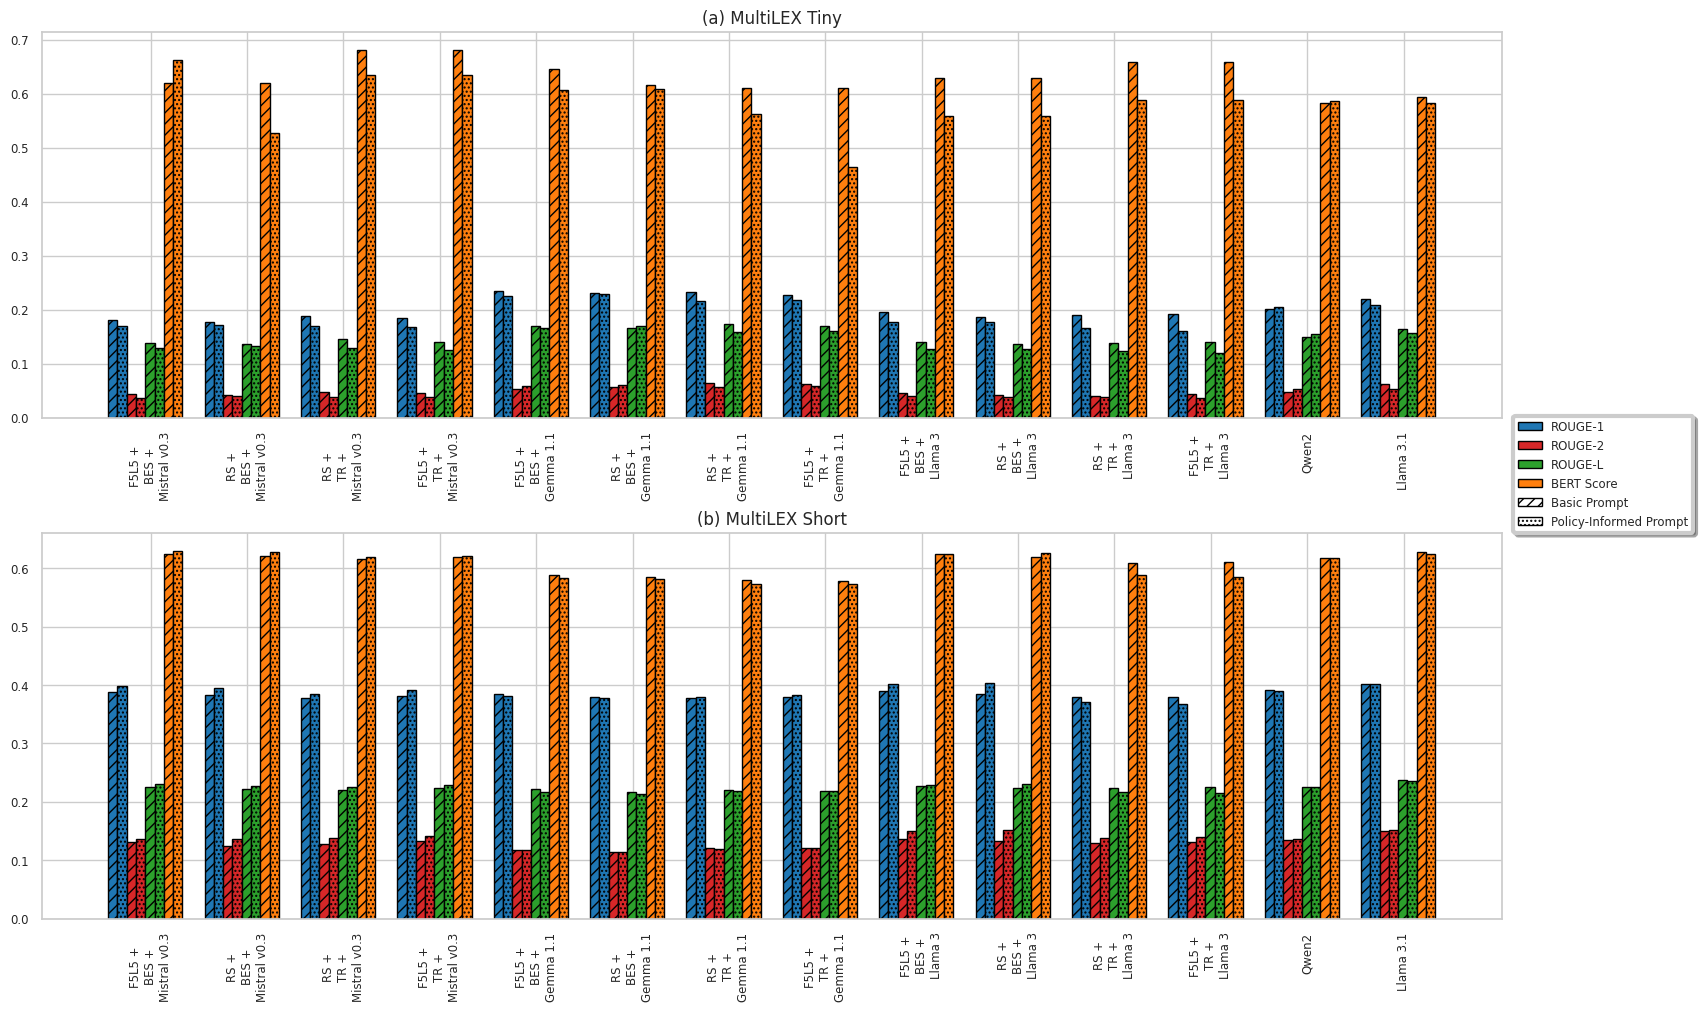

/tmp/ipykernel_3692/1606800066.py:86: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = plt.figlegend(handles=patches, ncols=1, frameon=True,loc="center", bbox_to_anchor=bbox_anchor, fontsize=8.5, shadow=True)


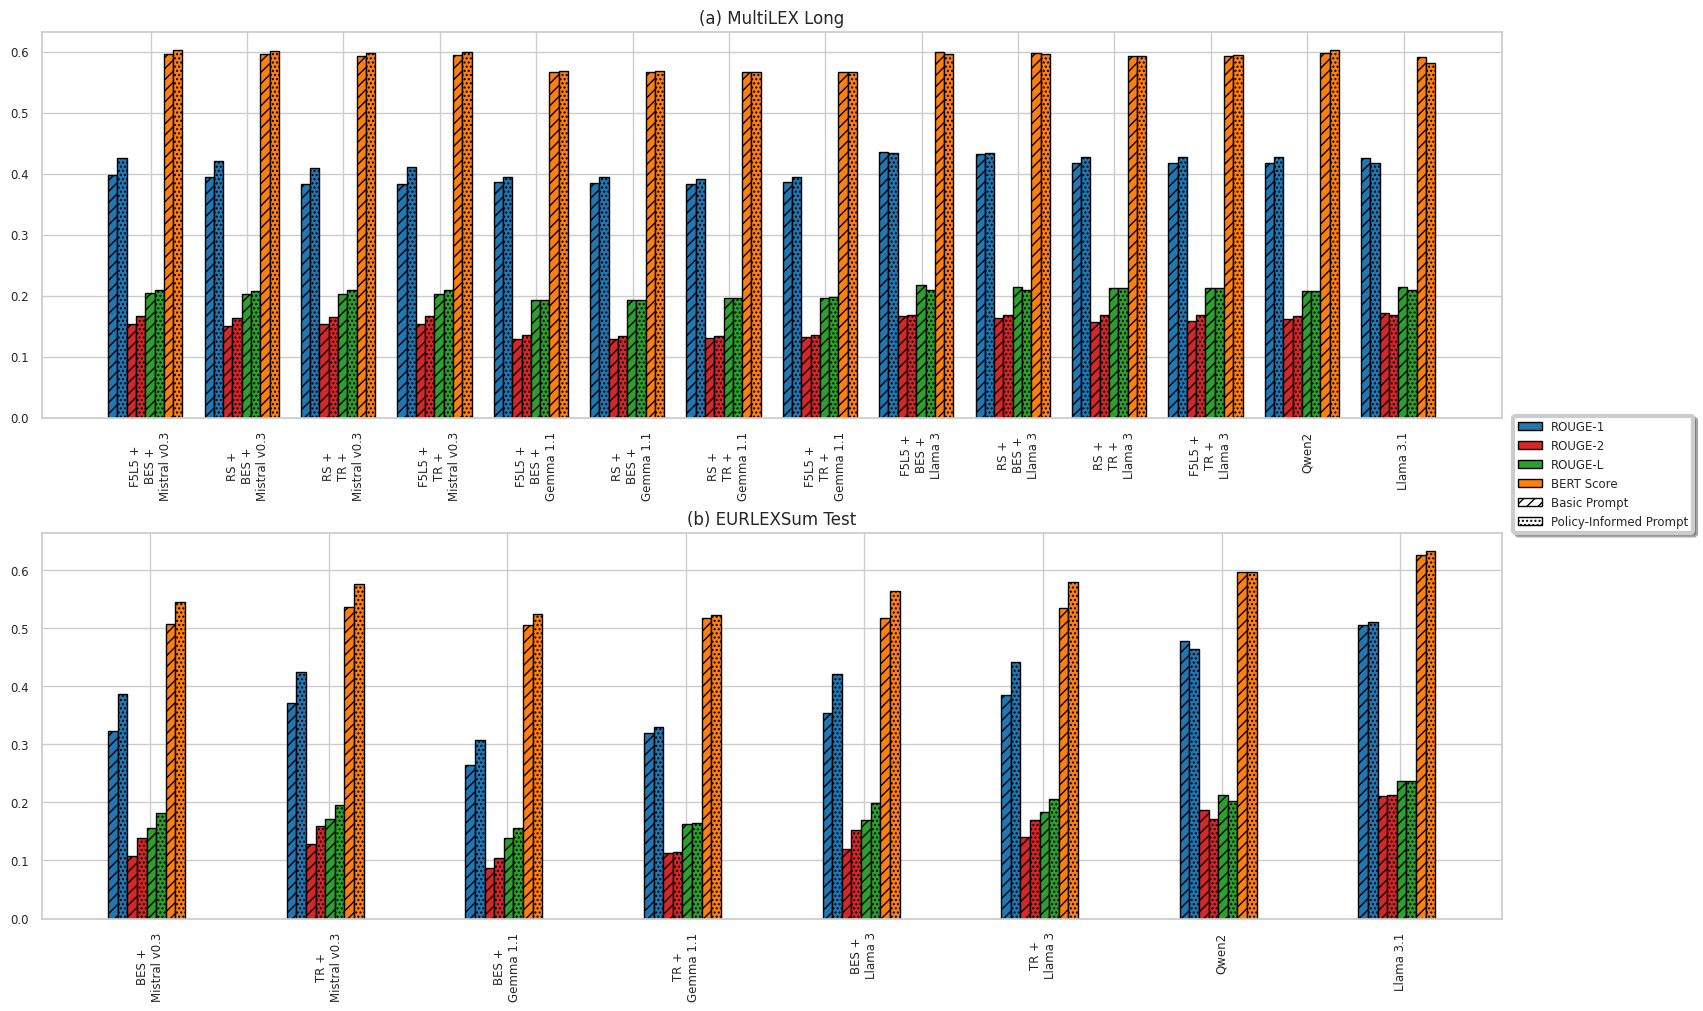

In [234]:
import numpy as np

def plot_results(iterator, fig, file_name, bbox_anchor):
    for (idx_dataset, (dataset_name, dataset_value)), ax in iterator:
        aux_df = dataset_value.copy(True)

        bar_padding = 1

        model_df = []
        for model in aux_df["Summarization approach"].unique():
            model_df += [aux_df[aux_df["Summarization approach"] == model]]

        aux_df_2 = pd.concat(model_df)

        #### R1 basic, R1 PI, R1 basic, R1 PI etc. - alternating to add adjancent columns

        r1 = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == "Basic")]["Score"].tolist()
        r2 = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == "Basic")]["Score"].tolist()
        rl = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == "Basic")]["Score"].tolist()
        bs = aux_df_2[(aux_df_2["Metric"] == "bert_score") & (aux_df_2["Prompt Template"] == "Basic")]["Score"].tolist()

        r1_pi = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Score"].tolist()
        r2_pi = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Score"].tolist()
        rl_pi = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Score"].tolist()
        bs_pi = aux_df_2[(aux_df_2["Metric"] == "bert_score") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Score"].tolist()

        scores = {
            "ROUGE-1": (r1, r1_pi),
            "ROUGE-2": (r2, r2_pi),
            "ROUGE-L": (rl, rl_pi),
            "BERT Score": (bs, bs_pi)
        }

        sns.set_theme(style="whitegrid")

        from matplotlib.patches import Patch

        models = aux_df_2["Summarization approach"].to_numpy()[::8]
        pos = np.arange(len(models))
        if "eurlexsum" in dataset_name:
            bar_spacing = 13
            width = 0.7
            multi = 0
        else:
            bar_spacing = 13.5
            width = 1.3
            multi = 0
        aux_pos = [pos[idx:idx+1] + bar_spacing*idx for idx in range(0,len(models),1)] ############ CHANGE TO 13
        pos = []
        offset = 0
        for p in aux_pos:
            p = p - offset
            pos += p.tolist()
            offset += 1
        pos = np.asarray(pos)
        colors = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
        for (metric, (vals, vals_pi)), color in zip(list(scores.items()), colors):
            bar_offset = width * multi
            rect = ax.bar(pos+2*bar_offset, vals, width, label=metric, hatch="", edgecolor="black", color=color)
            [patch.set(hatch="///") for patch in rect.patches]
            rect_pi = ax.bar(pos+2*bar_offset+width, vals_pi, width, label=None, hatch="....", edgecolor="black", color=color) ############# REMOVE +0.4
            # ax.bar_label(rect, padding=3, rotation=90)
            # ax.bar_label(rect_pi, padding=3, rotation=90)
            multi+=1

        models = [" +\n".join(model.split(" + ")) for model in models]
        if "eurlexsum" not in dataset_name:
            ax.set_xticks(pos+width+4, models, rotation=90)
        else:
            ax.set_xticks(pos+width+2, models, rotation=90)
        
        ax.tick_params(labelsize=8.5)
        subplot_title = f"({chr(idx_dataset + 97)}) {dataset_map[dataset_name]}"
        ax.set_title(subplot_title)

    legend = plt.figlegend(ncols=4, frameon=False,loc="upper center", bbox_to_anchor=bbox_anchor, fontsize="x-large")
    [legend_patch.set_hatch("") for legend_patch in legend.get_patches()]
    [legend_patch.set_label(metric_name) for legend_patch, metric_name in zip(legend.get_patches(), scores.keys())]
    legend.remove()

    patches = legend.legend_handles
    patch_basic = Patch(hatch="///",edgecolor="black", facecolor="white", label="Basic Prompt")
    patch_pi = Patch(hatch="....",edgecolor="black", facecolor="white", label="Policy-Informed Prompt")
    patches += [patch_basic, patch_pi]

    legend = plt.figlegend(handles=patches, ncols=1, frameon=True,loc="center", bbox_to_anchor=bbox_anchor, fontsize=8.5, shadow=True)
    legend.get_frame().set_linewidth(3)
    fig.get_layout_engine().set(wspace=0.15)
    plt.savefig(file_name, format="pdf", dpi=1200, bbox_inches="tight")
    plt.show()
    
figsize = (15,10)
fig, axes = plt.subplots(2, 1, figsize=figsize, layout="constrained")
axes = axes.flatten()
iterator = zip(enumerate(list(dataset_tables.items())[:2]), axes)
bbox_anchor = (1.065,0.531)

plot_results(iterator, fig, f"results_barplot_combined_all_tiny_short.pdf", bbox_anchor)

fig, axes = plt.subplots(2, 1, figsize=figsize, layout="constrained")
axes = axes.flatten()
iterator = zip(enumerate(list(dataset_tables.items())[2:]), axes)
bbox_anchor = (1.065,0.531)

plot_results(iterator, fig, f"results_barplot_combined_all_long_eurlex.pdf", bbox_anchor)

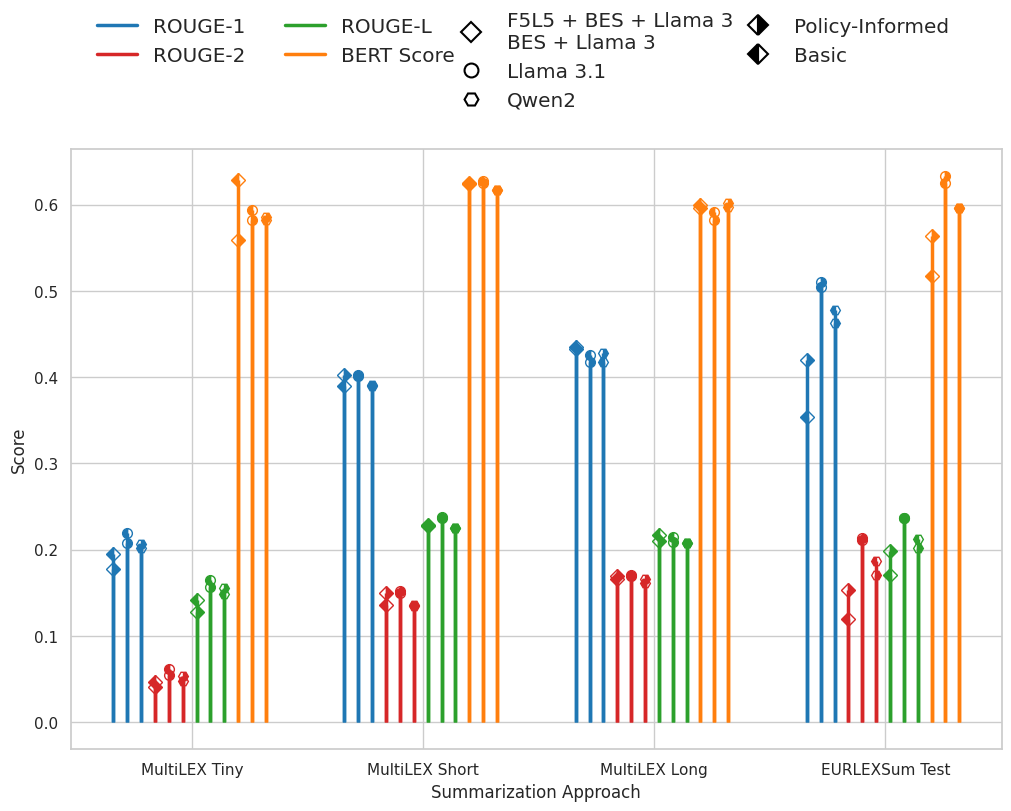

In [200]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(layout="constrained", figsize=(10,8))
middle_pos = []
models = [[], [], []]
for idx_dataset, (dataset_name, dataset_value) in enumerate(dataset_tables.items()):
    aux_df = dataset_value.copy(True)
    if "eurlexsum" not in dataset_name:
        aux_df_f5l5_bes_llama_llama31_qwen = aux_df[(aux_df["Summarization approach"] == "F5L5 + BES + Llama 3") | (aux_df["Summarization approach"] == "Qwen2") | (aux_df["Summarization approach"] == "Llama 3.1")]
    else:
        aux_df_f5l5_bes_llama_llama31_qwen = aux_df[(aux_df["Summarization approach"] == "BES + Llama 3") | (aux_df["Summarization approach"] == "Qwen2") | (aux_df["Summarization approach"] == "Llama 3.1")]
    
    aux_df_f5l5_bes_llama_llama31_qwen = aux_df_f5l5_bes_llama_llama31_qwen.sort_values(by=["Summarization approach", "Prompt Template"])
    [name_slot.append(model) if model not in name_slot else None for name_slot, model in zip(models, aux_df_f5l5_bes_llama_llama31_qwen["Summarization approach"].unique())]

    r1 = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "rouge1") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Basic")]["Score"].tolist()
    r2 = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "rouge2") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Basic")]["Score"].tolist()
    rl = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "rougeL") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Basic")]["Score"].tolist()
    bs = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "bert_score") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Basic")]["Score"].tolist()

    r1_pi = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "rouge1") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Policy-Informed")]["Score"].tolist()
    r2_pi = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "rouge2") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Policy-Informed")]["Score"].tolist()
    rl_pi = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "rougeL") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Policy-Informed")]["Score"].tolist()
    bs_pi = aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Metric"] == "bert_score") & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Policy-Informed")]["Score"].tolist()

    scores = {
        "ROUGE-1": (r1, r1_pi),
        "ROUGE-2": (r2, r2_pi),
        "ROUGE-L": (rl, rl_pi),
        "BERT Score": (bs, bs_pi)
    }

    scores_per_model_basic = {
        model: aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Summarization approach"] == model) & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Basic")]["Score"] for model in aux_df_f5l5_bes_llama_llama31_qwen["Summarization approach"].unique()
    }

    scores_per_model_pi = {
        model: aux_df_f5l5_bes_llama_llama31_qwen[(aux_df_f5l5_bes_llama_llama31_qwen["Summarization approach"] == model) & (aux_df_f5l5_bes_llama_llama31_qwen["Prompt Template"] == "Policy-Informed")]["Score"] for model in aux_df_f5l5_bes_llama_llama31_qwen["Summarization approach"].unique()
    }

    colors = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
    markers = ["D", "o", "H"]
    stem_score_closeness = 0.8
    stem_model_closeness = 0.6
    dataset_closeness = 10

    for idx_model, ((model, score_vals), marker) in enumerate(zip(list(scores_per_model_basic.items()), markers)):
        # score_values = score_values.to_numpy()
        pos_offset = np.arange(len(score_vals))*stem_score_closeness + idx_dataset*dataset_closeness + idx_model*stem_model_closeness
        for idx_color, (color, val, offset) in enumerate(zip(colors, score_vals[:4], pos_offset)):
            stem_fig = plt.stem(offset+idx_color, val, label=model, linefmt=color, basefmt="", markerfmt=marker)
            stem_fig.stemlines.set_linewidth(2.5)
            stem_fig.markerline.set_fillstyle("left") # basic
            stem_fig.markerline.set_markersize(7)

    for idx_model, ((model, score_vals), marker) in enumerate(zip(list(scores_per_model_pi.items()), markers)):
        # score_values = score_values.to_numpy()
        pos_offset = np.arange(len(score_vals))*stem_score_closeness + idx_dataset*dataset_closeness + idx_model*stem_model_closeness
        for idx_color, (color, val, offset) in enumerate(zip(colors, score_vals[:4], pos_offset)):
            stem_fig = plt.stem(offset+idx_color, val, label=model, linefmt=color, basefmt="", markerfmt=marker)
            stem_fig.stemlines.set_linewidth(2.5)
            stem_fig.markerline.set_fillstyle("right") # PI
            stem_fig.markerline.set_markersize(7)


    middle_pos += [np.mean(pos_offset)]
    
from matplotlib.lines import Line2D

# print([(model, marker) for model, marker in zip(scores_per_model_pi, markers)])
handles_scores = [Line2D([],[],lw=2.5,label=metric,color=color) for color,metric in zip(colors, scores.keys())]
handles_models = [Line2D([],[],lw=0,marker=marker,label="\n".join(model),markerfacecolor="white",color="black",markeredgewidth=1.5, markersize=10) for model, marker in zip(models, markers)]
handles_prompts = [Line2D([],[],lw=0,marker="D",label=prompt_type,markerfacecolor="black",color="black",markeredgewidth=1.5,fillstyle=fill_type, markersize=10) for prompt_type, fill_type in zip(["Policy-Informed", "Basic"], ["right", "left"])]

legend_scores = plt.legend(handles=handles_scores, ncols=2, frameon=False, loc="upper center", bbox_to_anchor=(0.22, 1.25), fontsize="large")
legend_models = plt.legend(handles=handles_models, ncols=1, frameon=False, loc="upper center", bbox_to_anchor=(0.56, 1.26), fontsize="large")
legend_prompts = plt.legend(handles=handles_prompts, ncols=1, frameon=False, loc="upper center", bbox_to_anchor=(0.83, 1.25), fontsize="large")

plt.gca().add_artist(legend_scores)
plt.gca().add_artist(legend_models)

legend_labels = [dataset_map[dataset_name] for dataset_name in dataset_tables.keys()]
middle_pos = np.asarray(middle_pos)+1
plt.ylabel("Score")
plt.xlabel("Summarization Approach")
plt.xticks(ticks=middle_pos, labels=legend_labels)
plt.savefig("stemplot_alldatasets_llama3_qwen2_llama31.pdf", format="pdf", dpi=1200)
plt.show()

In [270]:
rouge_scores = pickle.load(open("../rouge_breakdown_all.pickle", "rb"))

In [271]:
rouge_scores.keys()
dataset_rouge_scores = defaultdict(list)
for model in rouge_scores.keys():
    if "cod" in model:
        continue
    components = model.split("/")
    dataset, model_name = components[0], "/".join(components[1:])
    dataset_rouge_scores[dataset] += [{model_name: rouge_scores[model]}]

dataset_rouge_scores.pop("eurlexsum"), dataset_rouge_scores.pop("eurlexsum_validation")

([{'Mistral-7B-Instruct-v0.3/detailed/random_selection_bert': {'rouge1': {'precision': [0.6885714285714286,
      0.7921052631578948,
      0.7595959595959596,
      0.7467362924281984,
      0.7177615571776156,
      0.7452574525745257,
      0.8176638176638177,
      0.7580246913580246,
      0.5690721649484536,
      0.789598108747045,
      0.7549019607843137,
      0.670299727520436,
      0.6369230769230769,
      0.6782945736434108,
      0.6582278481012658,
      0.7044776119402985,
      0.6889400921658986,
      0.6071428571428571,
      0.7782340862422998,
      0.6547619047619048,
      0.7771587743732591,
      0.4419753086419753,
      0.6409395973154363,
      0.4666666666666667,
      0.5116279069767442,
      0.43967828418230565,
      0.6810810810810811,
      0.6291079812206573,
      0.4521072796934866,
      0.6586826347305389,
      0.7204968944099379,
      0.6875,
      0.710239651416122,
      0.7314814814814815,
      0.6995073891625616,
      0.73051948051948

In [272]:
datasets_rouge = {}
for dataset in dataset_rouge_scores.keys():
    df_rouge = {
        "model": [],
        "selection_type": [],
        "prompt_type": [],
        "score_type": [],
        "precision": [],
        "recall": [],
        "fmeasure": []
    }
    for model in dataset_rouge_scores[dataset]:
        for model_name, metrics in model.items():
            for metric, values in metrics.items():
                if len(model_name.split("/")) > 2:
                    model_name_split, prompt, selection_type = model_name.split("/")
                else:
                    selection_type = "None"
                    model_name_split, prompt = model_name.split("/")

                df_rouge["model"] += [model_name_split]
                df_rouge["prompt_type"] += [prompt]
                df_rouge["selection_type"] += [selection_type]
                df_rouge["score_type"] += [metric]
                for metric_breakdown, values_breakdown in values.items():
                    # print(model, metric, metric_breakdown, np.mean(values_breakdown))

                    df_rouge[metric_breakdown] += [np.mean(values_breakdown)]

    df = pd.DataFrame(df_rouge)
    df = df[~df["prompt_type"].str.contains("cod")] ########################## REMOVED COD
    df = df[~df["model"].str.contains("led")] ########################### REMOVE LED
    df = df[~df["model"].str.contains("primera")] ###################### REMOVE PRIMERA
    ###################################

    aux = df[df["model"].str.contains("llama3.1")]
    df = df[~df["model"].str.contains("llama3.1")]
    df = pd.concat([df, aux]) 

    df = df.reset_index(drop=True)
    if "eurlexsum" not in dataset:
        df["prompt_type"] = df["prompt_type"].apply(lambda x: prompt_type_map[x.split("_")[-1]])
    else:
        def get_prompt_type(x):
            x = x.split("_")
            if len(x) > 2:
                x = x[1]
            else:
                x = x[-1]
            return prompt_type_map[x]
        df["prompt_type"] = df["prompt_type"].apply(lambda x: get_prompt_type(x))

    df_aux = []
    for model_order in llm_order:
        df_aux += [df[df["model"] == model_order]]

    df = pd.concat(df_aux)

    if "eurlexsum" not in dataset:
        df["Summarization approach"] = df.apply(lambda x: (pipeline_map_name[x["selection_type"]] + " + " if x["selection_type"] != "None" else "") + model_map_name[x["model"]] , axis=1)
    else:
        df["Summarization approach"] = df.apply(lambda x: (pipeline_map_name_eurlexsum[x["selection_type"]] + " + " if x["selection_type"] != "None" else "") + model_map_name[x["model"]] , axis=1)

    df.columns = ['model', 'selection_type', 'Prompt Template', 'Metric', 'Precision', 'Recall', 'F-measure', 'Summarization approach']
    datasets_rouge[dataset] = df


/tmp/ipykernel_3692/3429125190.py:105: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = plt.figlegend(handles=patches, ncols=2, frameon=True,loc="center", bbox_to_anchor=bbox_anchor, fontsize=8.5, shadow=True)


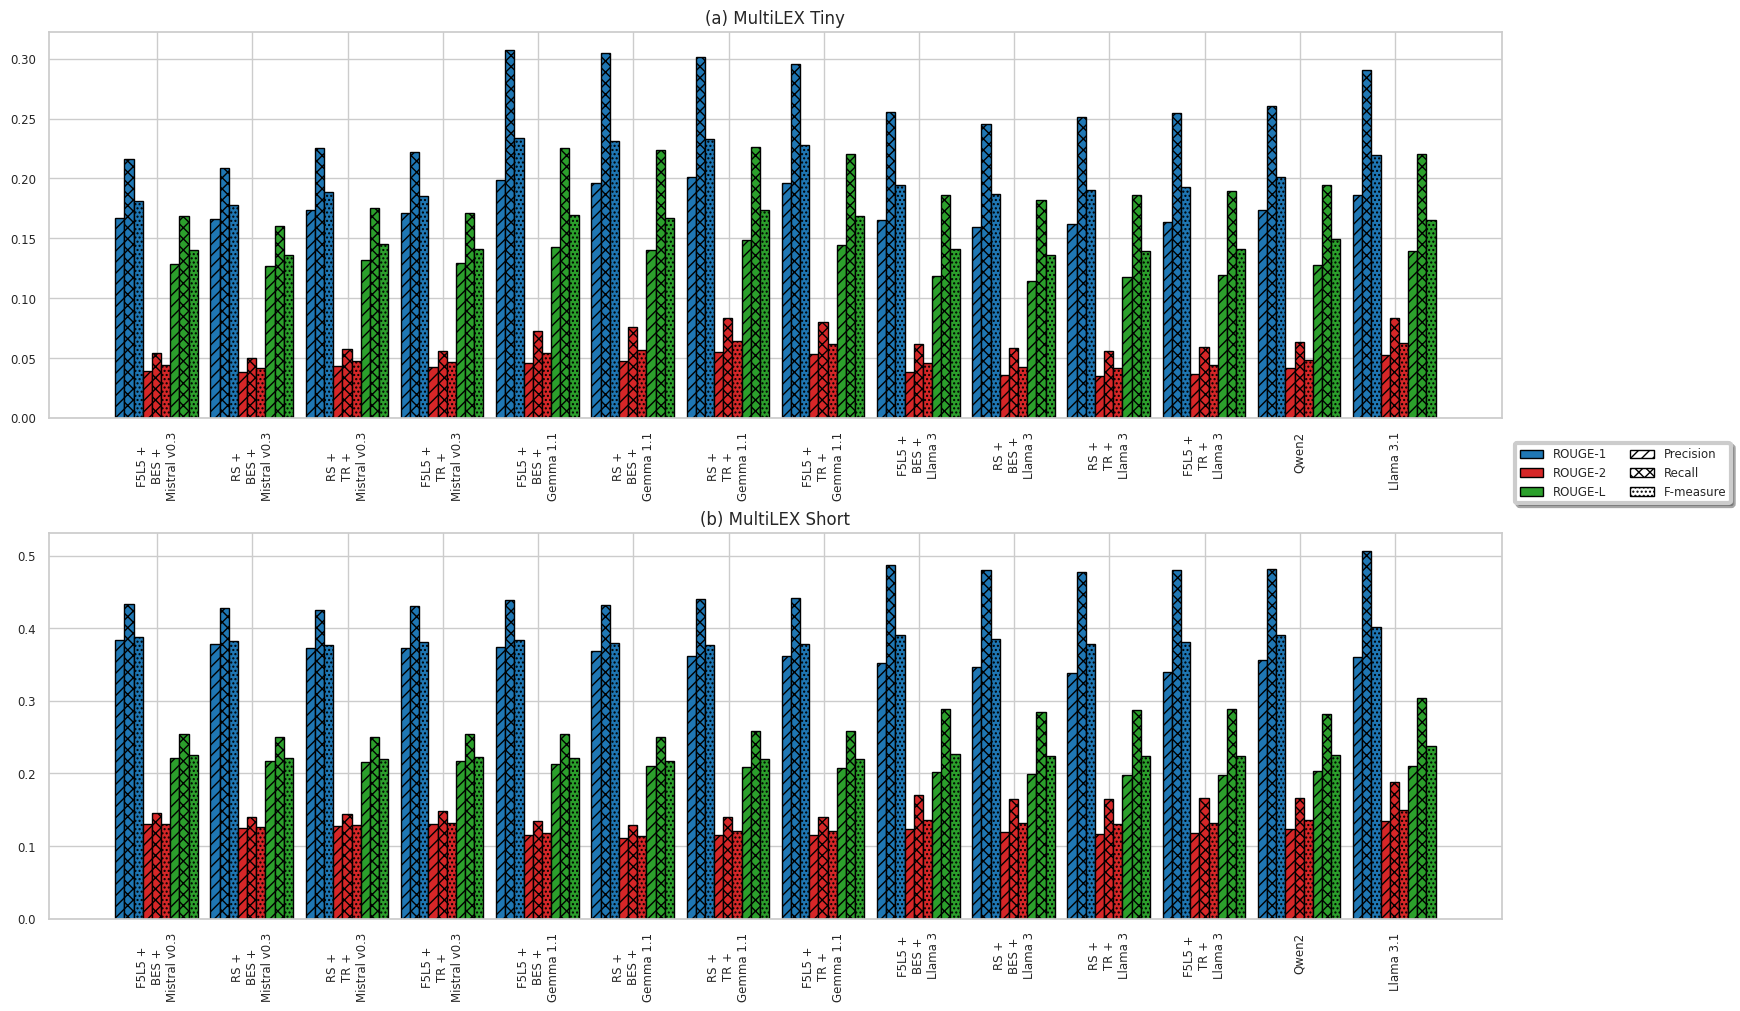

/tmp/ipykernel_3692/3429125190.py:105: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = plt.figlegend(handles=patches, ncols=2, frameon=True,loc="center", bbox_to_anchor=bbox_anchor, fontsize=8.5, shadow=True)


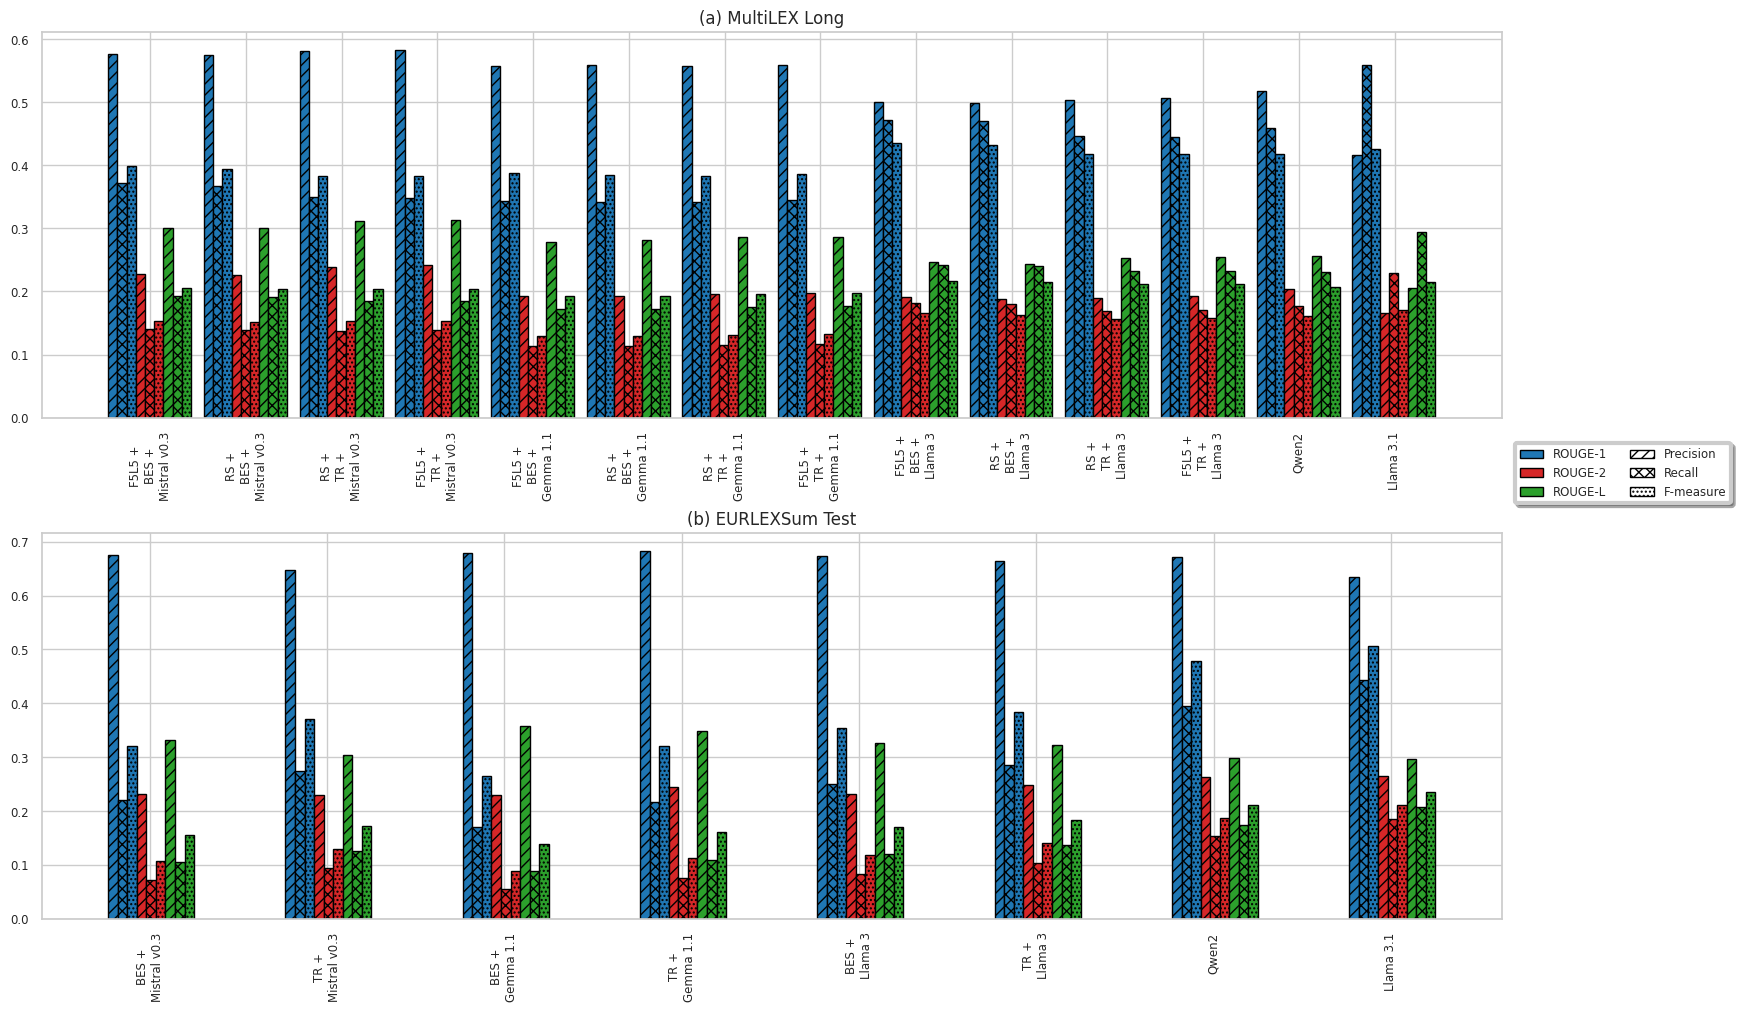

In [278]:
def plot_results(iterator, fig, file_name, bbox_anchor, prompt_type):
    for (idx_dataset, (dataset_name, dataset_value)), ax in iterator:
        aux_df = dataset_value.copy(True)

        bar_padding = 1

        model_df = []
        for model in aux_df["Summarization approach"].unique():
            model_df += [aux_df[aux_df["Summarization approach"] == model]]

        aux_df_2 = pd.concat(model_df)

        #### R1 basic, R1 PI, R1 basic, R1 PI etc. - alternating to add adjancent columns

        r1_precision = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == prompt_type)]["Precision"].tolist()
        r1_recall = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == prompt_type)]["Recall"].tolist()
        r1_f1 = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == prompt_type)]["F-measure"].tolist()

        r2_precision = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == prompt_type)]["Precision"].tolist()
        r2_recall = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == prompt_type)]["Recall"].tolist()
        r2_f1 = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == prompt_type)]["F-measure"].tolist()

        rl_precision = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == prompt_type)]["Precision"].tolist()
        rl_recall = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == prompt_type)]["Recall"].tolist()
        rl_f1 = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == prompt_type)]["F-measure"].tolist()

        ############# 
        # r1_precision_pi = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Precision"].tolist()
        # r1_recall_pi = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Recall"].tolist()
        # r1_f1_pi = aux_df_2[(aux_df_2["Metric"] == "rouge1") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["F-measure"].tolist()

        # r2_precision_pi = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Precision"].tolist()
        # r2_recall_pi = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Recall"].tolist()
        # r2_f1_pi = aux_df_2[(aux_df_2["Metric"] == "rouge2") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["F-measure"].tolist()

        # rl_precision_pi = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Precision"].tolist()
        # rl_recall_pi = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["Recall"].tolist()
        # rl_f1_pi = aux_df_2[(aux_df_2["Metric"] == "rougeL") & (aux_df_2["Prompt Template"] == "Policy-Informed")]["F-measure"].tolist()

        scores = {
            "ROUGE-1": (r1_precision, r1_recall, r1_f1),
            "ROUGE-2": (r2_precision, r2_recall, r2_f1),
            "ROUGE-L": (rl_precision, rl_recall, rl_f1),
        }


        sns.set_theme(style="whitegrid")

        from matplotlib.patches import Patch

        models = aux_df_2["Summarization approach"].to_numpy()[::6]
        pos = np.arange(len(models))
        if "eurlexsum" in dataset_name:
            bar_spacing = 13
            width = 0.7
            multi = 0
        else:
            bar_spacing = 13.5
            width = 1.3
            multi = 0

        number_of_bars = 3
        aux_pos = [pos[idx:idx+1] + bar_spacing*idx for idx in range(0,len(models),1)] ############ CHANGE TO 13
        pos = []
        offset = 0
        for p in aux_pos:
            p = p - offset
            pos += p.tolist()
            offset += 1
        pos = np.asarray(pos)
        colors = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
        for (metric, (r_precision, r_recall, r_f1)), color in zip(list(scores.items()), colors):
            bar_offset = width * multi
            rect_precision = ax.bar(pos+number_of_bars*bar_offset, r_precision, width, label=metric, hatch="", edgecolor="black", color=color)
            [patch.set(hatch="///") for patch in rect_precision.patches]
            rect_recall = ax.bar(pos+number_of_bars*bar_offset+width, r_recall, width, label=None, hatch="xxx", edgecolor="black", color=color) ############# REMOVE +0.4
            rect_fmeasure = ax.bar(pos+number_of_bars*bar_offset+2*width, r_f1, width, label=None, hatch="....", edgecolor="black", color=color) ############# REMOVE +0.4
            
            # ax.bar_label(rect, padding=3, rotation=90)
            # ax.bar_label(rect_pi, padding=3, rotation=90)
            multi+=1

        models = [" +\n".join(model.split(" + ")) for model in models]
        if "eurlexsum" not in dataset_name:
            ax.set_xticks(pos+width+4, models, rotation=90)
        else:
            ax.set_xticks(pos+width+2, models, rotation=90)
            

        ax.tick_params(labelsize=8.5)
        subplot_title = f"({chr(idx_dataset + 97)}) {dataset_map[dataset_name]}"
        ax.set_title(subplot_title)

    legend = plt.figlegend(ncols=4, frameon=False,loc="upper center", bbox_to_anchor=bbox_anchor, fontsize="x-large")
    [legend_patch.set_hatch("") for legend_patch in legend.get_patches()]
    [legend_patch.set_label(metric_name) for legend_patch, metric_name in zip(legend.get_patches(), scores.keys())]
    legend.remove()

    patches = legend.legend_handles
    patch_precision = Patch(hatch="///",edgecolor="black", facecolor="white", label="Precision")
    patch_recall = Patch(hatch="xxx",edgecolor="black", facecolor="white", label="Recall")
    patch_fmeasure = Patch(hatch="....",edgecolor="black", facecolor="white", label="F-measure")
    patches += [patch_precision, patch_recall, patch_fmeasure]

    legend = plt.figlegend(handles=patches, ncols=2, frameon=True,loc="center", bbox_to_anchor=bbox_anchor, fontsize=8.5, shadow=True)
    legend.get_frame().set_linewidth(3)
    fig.get_layout_engine().set(wspace=0.15)
    plt.savefig(file_name, format="pdf", dpi=1200, bbox_inches="tight")
    plt.show()

prompt_type = "Basic"
# prompt_type = "Policy-Informed"

figsize = (15,10)
fig, axes = plt.subplots(2, 1, figsize=figsize, layout="constrained")
axes = axes.flatten()
iterator = zip(enumerate(list(datasets_rouge.items())[:2]), axes)
bbox_anchor = (1.078,0.532)

plot_results(iterator, fig, f"rouge_breakdown_tiny_short_{prompt_type}.pdf", bbox_anchor, prompt_type)

figsize = (15,10)
fig, axes = plt.subplots(2, 1, figsize=figsize, layout="constrained")
axes = axes.flatten()
iterator = zip(enumerate(list(datasets_rouge.items())[2:]), axes)
bbox_anchor = (1.078, 0.532)

plot_results(iterator, fig, f"rouge_breakdown_long_eurlexsum_{prompt_type}.pdf", bbox_anchor, prompt_type)